# Figure 03

Short description: This is mainly data prep

## Import libraries

In [264]:
import glob
import os
import pickle
import re
import sys
import time

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from matplotlib.colors import ListedColormap, LogNorm, LinearSegmentedColormap
from scipy.stats import poisson

## Parameters and functions

In [2]:
def extract_values(filename):
    fsplit = re.split(r"/|_|,", filename.split(".gzip")[0])
    return tuple(map(float, [fsplit[fsplit.index("popsize")+1], fsplit[fsplit.index("delmutrate")+1], fsplit[fsplit.index("selcoeff")+1]]))

# Data and processing

In [3]:
path = "v01/results/table/*.gzip"
files = glob.glob(path)
sorted_filenames = sorted(files, key=extract_values)
#print(np.array(sorted_filenames))

In [4]:
params_list = []
click_rate_list = []
profile_list = []

for f in sorted_filenames:
    df = pd.read_pickle(f)

    # assert the random number seed
    assert all(len(df[_].unique()) == 1 for _ in ("N", "s", "U")), "Your table is not unique on the parameters"
    assert not df["rng_seed"].duplicated().any(), "You reused the same rng_seed for your simulation"


    # get click_rate
    click_rate = df["click_rate"]
    
    # get profiles
    max_length = df["profile"].apply(len).max()
    profile = pd.DataFrame(df["profile"].apply(lambda x: np.pad(x, (0, max_length - len(x)), 'constant')).to_list(), columns=range(max_length))

    # remove profile from original data frame
    df.drop("profile", axis=1, inplace=True)
    df.drop("click_rate", axis=1, inplace=True)

    # save data to list
    params_list.append(df)
    click_rate_list.append(click_rate)
    profile_list.append(profile)

In [5]:
click_rate_complete = pd.concat([pd.concat(params_list), pd.concat(click_rate_list)], axis=1)
click_rate_complete["Ns"] = click_rate_complete["N"] * click_rate_complete["s"]
click_rate_complete["NU"] = click_rate_complete["N"].astype(str) + "_" + click_rate_complete["U"].astype(str)
click_rate_complete = click_rate_complete.loc[click_rate_complete["s"] > 0]

In [6]:
click_rate_complete.U.unique(), click_rate_complete.N.unique(), click_rate_complete.s.unique()

(array([7.70e-04, 4.00e-03, 6.00e-03, 1.00e-04, 3.16e-04, 1.00e-03,
        3.16e-03, 1.00e-02, 3.16e-02, 1.00e-01, 3.16e-01, 1.00e+00,
        3.16e+00]),
 array([2000, 5000]),
 array([2.0e-06, 1.0e-05, 5.0e-05, 1.0e-04, 1.5e-04, 4.0e-04, 1.0e-03,
        2.0e-03, 4.1e-03, 1.0e-02, 1.0e-01, 1.0e+00, 2.5e-05, 8.0e-06,
        2.0e-05, 8.0e-05, 2.0e-04, 8.0e-04, 8.0e-03, 2.0e-02, 8.0e-02,
        2.0e-01, 4.0e-05, 6.0e-05]))

## Visualisation

## Panel C

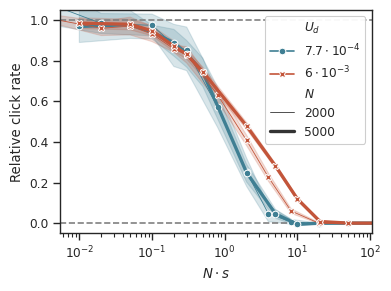

In [7]:
sns.set(context="paper", style="ticks", font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))


ax.axhline(0, linestyle="dashed", color="gray")
ax.axhline(1, linestyle="dashed", color="gray")


sns.lineplot(
    click_rate_complete.loc[click_rate_complete.U.isin((0.00077, 0.006))],
    x="Ns",
    y="click_rate",
    hue="U",
    size="N",
    style="U",
    markers=True,
    dashes=False,
    errorbar=("ci", 95),
    palette=sns.diverging_palette(220, 20, as_cmap=True),
    #palette=["Orange", "Blue"],
    ax=ax
)

ax.set_xscale("log")
ax.set_xlim(5.5e-3, 1.05*1e2)
ax.set_ylim(-0.05, 1.05)

legend = ax.legend(loc="upper right", framealpha=0.95)
legend.texts[0].set_text("$U_d$")
legend.texts[1].set_text("$7.7 \cdot 10^{-4}$")
legend.texts[2].set_text("$6 \cdot 10^{-3}$")
legend.texts[3].set_text("$N$")

#plt.legend(loc="upper right", framealpha=0.95)


ax.set_xlabel("$N \cdot s$")
ax.set_ylabel("Relative click rate")


plt.tight_layout()
plt.show()
plt.close()

(N, s, U) [5000] [0.08] [0.001]


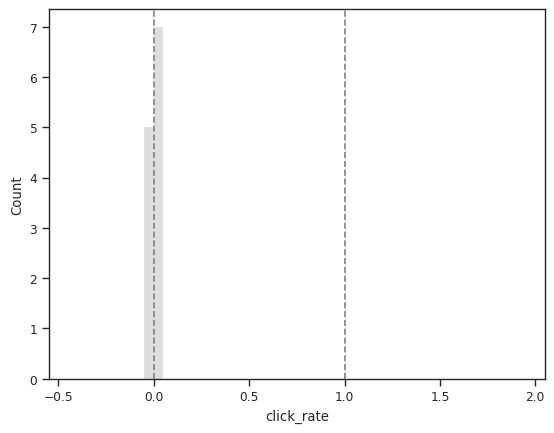

In [8]:
lid = 80
print("(N, s, U)", params_list[lid].N.unique(), params_list[lid].s.unique(), params_list[lid].U.unique())
sns.histplot(click_rate_list[lid], bins=np.arange(-5, 5, 0.05), line_kws=dict(c="gray"), color="lightgray")
plt.xlim(-0.55, 2.05)
plt.axvline(0, linestyle="dashed", color="gray")
plt.axvline(1, linestyle="dashed", color="gray")
plt.show()
plt.close()

In [9]:
nsub = click_rate_complete.loc[click_rate_complete.N == 5000]
nsub = nsub.loc[nsub.U.isin([1e-4, 1e-3, 1e-2, 1e-1, 1, 3.16e-4, 3.16e-3, 3.16e-2, 3.16e-1, 3.16])]
nsub["lU"] = np.log(nsub["U"])
print(sorted(nsub.U.unique()))
nsub.head()

[0.0001, 0.000316, 0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316, 1.0, 3.16]


,rng_seed,N,s,U,click_rate,Ns,NU,lU
0,2283182489,5000,0.000002,0.0001,0.106459,0.01,5000_0.0001,-9.21034
1,3063854464,5000,0.000002,0.0001,-0.593985,0.01,5000_0.0001,-9.21034
2,335197160,5000,0.000002,0.0001,-0.388446,0.01,5000_0.0001,-9.21034
3,2609705121,5000,0.000002,0.0001,0.219464,0.01,5000_0.0001,-9.21034
4,3948923896,5000,0.000002,0.0001,0.630534,0.01,5000_0.0001,-9.21034


## Sfig3

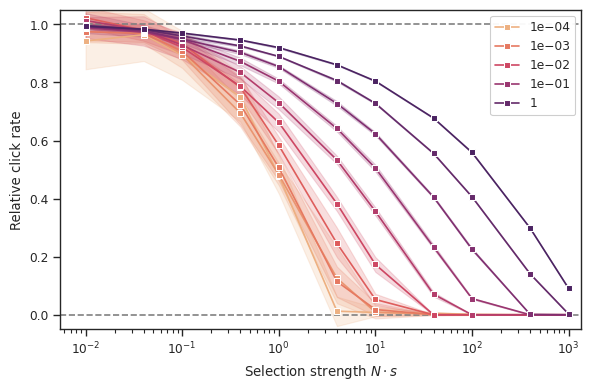

In [337]:
sns.set(context="paper", style="ticks", font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))


ax.axhline(0, linestyle="dashed", color="gray")
ax.axhline(1, linestyle="dashed", color="gray")

sns.lineplot(
    nsub,
    x="Ns",
    y="click_rate",
    hue="U",
    hue_norm=LogNorm(),
    #style=10,
    marker="s",
    dashes=False,
    errorbar=("ci", 95),
    #palette=sns.diverging_palette(220, 20, as_cmap=True),
    #palette=["Orange", "Blue"],
    palette="flare",
    #err_style="bars",
    ax=ax
)

ax.set_xscale("log")
ax.set_xlim(5.5e-3, 1.35e3)
ax.set_ylim(-0.05, 1.05)

plt.legend(loc="upper right", framealpha=0.95)


ax.set_xlabel("Selection strength $  N \cdot s  $")
ax.set_ylabel("Relative click rate")

plt.tight_layout()
plt.show()
plt.close()

(N, s, U) [5000] [2.e-05] [0.01]


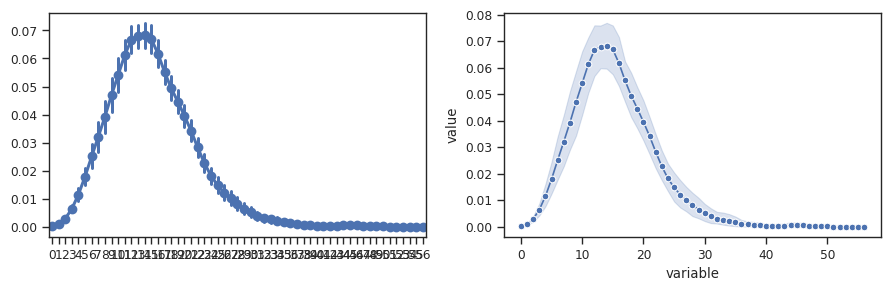

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

lid = 120
print("(N, s, U)", params_list[lid].N.unique(), params_list[lid].s.unique(), params_list[lid].U.unique())
sns.pointplot(
    profile_list[lid],
    errorbar="se", 
    ax = ax[0]
)
#plt.legend().remove()

a = profile_list[lid].melt()
a["id"] = "NA"
sns.lineplot(
    a,
    x="variable",
    y="value",
    style="id",
    markers=True,
    dashes=False,
    ax = ax[1]
)

plt.legend().remove()

plt.tight_layout()
plt.show()
plt.close()

In [298]:
# subset data
# identify the indices
parid_list = []
N_list, s_list, U_list = [], [], []
for parid, params in enumerate(params_list):
    assert len(params.N.unique()) == 1, f"The parameter for this dataset is not unique: {params.N.unique()}"
    assert len(params.s.unique()) == 1, f"The parameter for this dataset is not unique: {params.s.unique()}"
    assert len(params.U.unique()) == 1, f"The parameter for this dataset is not unique: {params.U.unique()}"

    parid_list.append(parid)
    N_list.append(params.N.unique()[0])
    s_list.append(params.s.unique()[0])
    U_list.append(params.U.unique()[0])

params_df = pd.DataFrame(dict(N = N_list, s=s_list, U=U_list), index=parid_list)
assert not params_df.duplicated().any(), "You have parameter duplicates"

params_df["Ns"] = params_df["N"] * params_df["s"]
params_df_006 = params_df.loc[params_df["U"] == 0.006]
params_df_00077 = params_df.loc[params_df["U"] == 0.00077]

params_df_006_2k = params_df_006.loc[params_df_006["N"] == 2000]
params_df_00077_2k = params_df_00077.loc[params_df_00077["N"] == 2000]

params_df_006 = params_df_006.loc[params_df_006["N"] == 5000]
params_df_00077 = params_df_00077.loc[params_df_00077["N"] == 5000]

assert ((np.array(sorted(params_df_006.Ns.unique())) == np.array(sorted(params_df_00077.Ns.unique()))).all()), "Not same selection strength; this may require a better subsetting"

In [299]:
profile_006_list = []
for pid in params_df_006.index:
    df = profile_list[pid]
    df["N"] = int(round(params_df_006.loc[pid, :].N))
    df["s"] = params_df_006.loc[pid, :].s
    df["U"] = params_df_006.loc[pid, :].U
    df["NsU"] = df["N"].apply(str) + "_" + df["s"].apply(str) + "_" + df["U"].apply(str)
    df["click_rate"] = click_rate_list[pid].mean()

    profile_006_list.append(df.melt(id_vars=["N", "s", "U", "NsU", "click_rate"], var_name="$h_k$", value_name="freq"))

profile_006_long = pd.concat(profile_006_list)
profile_006_long["$Ns$"] = profile_006_long["N"] * profile_006_long["s"]
profile_006_long["Strength"] = profile_006_long["click_rate"].apply(lambda x: "strong" if x < 0.01 else "weak")
#pd.concat([profile_list[_].assign() for _ in params_df_006.index])
profile_006_long.head()

,N,s,U,NsU,click_rate,$h_k$,freq,$Ns$,Strength
0,5000,0.0,0.006,5000_0.0_0.006,0.995939,0,0.000344,0.0,weak
1,5000,0.0,0.006,5000_0.0_0.006,0.995939,0,0.000591,0.0,weak
2,5000,0.0,0.006,5000_0.0_0.006,0.995939,0,0.000057,0.0,weak
3,5000,0.0,0.006,5000_0.0_0.006,0.995939,0,0.000421,0.0,weak
4,5000,0.0,0.006,5000_0.0_0.006,0.995939,0,0.001040,0.0,weak


In [300]:
profile_006_2k_list = []
for pid in params_df_006_2k.index:
    df = profile_list[pid]
    df["N"] = int(round(params_df_006_2k.loc[pid, :].N))
    df["s"] = params_df_006_2k.loc[pid, :].s
    df["U"] = params_df_006_2k.loc[pid, :].U
    df["NsU"] = df["N"].apply(str) + "_" + df["s"].apply(str) + "_" + df["U"].apply(str)
    df["click_rate"] = click_rate_list[pid].mean()

    profile_006_2k_list.append(df.melt(id_vars=["N", "s", "U", "NsU", "click_rate"], var_name="$h_k$", value_name="freq"))

profile_006_2k_long = pd.concat(profile_006_2k_list)
profile_006_2k_long["$Ns$"] = profile_006_2k_long["N"] * profile_006_2k_long["s"]
profile_006_2k_long["Strength"] = profile_006_2k_long["click_rate"].apply(lambda x: "strong" if x < 0.01 else "weak")
#pd.concat([profile_list[_].assign() for _ in params_df_006.index])
profile_006_2k_long.head()

,N,s,U,NsU,click_rate,$h_k$,freq,$Ns$,Strength
0,2000,0.000002,0.006,2000_2e-06_0.006,1.006694,0,0.003995,0.004,weak
1,2000,0.000002,0.006,2000_2e-06_0.006,1.006694,0,0.001412,0.004,weak
2,2000,0.000002,0.006,2000_2e-06_0.006,1.006694,0,0.007871,0.004,weak
3,2000,0.000002,0.006,2000_2e-06_0.006,1.006694,0,0.000959,0.004,weak
4,2000,0.000002,0.006,2000_2e-06_0.006,1.006694,0,0.000861,0.004,weak


In [301]:
profile_00077_list = []
for pid in params_df_00077.index:
    df = profile_list[pid]
    df["N"] = int(round(params_df_00077.loc[pid, :].N))
    df["s"] = params_df_00077.loc[pid, :].s
    df["U"] = params_df_00077.loc[pid, :].U
    df["NsU"] = df["N"].apply(str) + "_" + df["s"].apply(str) + "_" + df["U"].apply(str)
    df["click_rate"] = click_rate_list[pid].mean()

    profile_00077_list.append(df.melt(id_vars=["N", "s", "U", "NsU", "click_rate"], var_name="$h_k$", value_name="freq"))

profile_00077_long = pd.concat(profile_00077_list)
profile_00077_long["$Ns$"] = profile_00077_long["N"] * profile_00077_long["s"]
profile_00077_long["Strength"] = profile_00077_long["click_rate"].apply(lambda x: "strong" if x < 0.01 else "weak")
#pd.concat([profile_list[_].assign() for _ in params_df_006.index])
profile_00077_long.head()

,N,s,U,NsU,click_rate,$h_k$,freq,$Ns$,Strength
0,5000,0.0,0.00077,5000_0.0_0.00077,0.983176,0,0.035110,0.0,weak
1,5000,0.0,0.00077,5000_0.0_0.00077,0.983176,0,0.046445,0.0,weak
2,5000,0.0,0.00077,5000_0.0_0.00077,0.983176,0,0.011648,0.0,weak
3,5000,0.0,0.00077,5000_0.0_0.00077,0.983176,0,0.007980,0.0,weak
4,5000,0.0,0.00077,5000_0.0_0.00077,0.983176,0,0.011843,0.0,weak


In [302]:
profile_00077_2k_list = []
for pid in params_df_00077_2k.index:
    df = profile_list[pid]
    df["N"] = int(round(params_df_00077_2k.loc[pid, :].N))
    df["s"] = params_df_00077_2k.loc[pid, :].s
    df["U"] = params_df_00077_2k.loc[pid, :].U
    df["NsU"] = df["N"].apply(str) + "_" + df["s"].apply(str) + "_" + df["U"].apply(str)
    df["click_rate"] = click_rate_list[pid].mean()

    profile_00077_2k_list.append(df.melt(id_vars=["N", "s", "U", "NsU", "click_rate"], var_name="$h_k$", value_name="freq"))

profile_00077_2k_long = pd.concat(profile_00077_2k_list)
profile_00077_2k_long["$Ns$"] = profile_00077_2k_long["N"] * profile_00077_2k_long["s"]
profile_00077_2k_long["Strength"] = profile_00077_2k_long["click_rate"].apply(lambda x: "strong" if x < 0.01 else "weak")
#pd.concat([profile_list[_].assign() for _ in params_df_006.index])
profile_00077_2k_long.head()

,N,s,U,NsU,click_rate,$h_k$,freq,$Ns$,Strength
0,2000,0.000002,0.00077,2000_2e-06_0.00077,1.07714,0,0.067134,0.004,weak
1,2000,0.000002,0.00077,2000_2e-06_0.00077,1.07714,0,0.037939,0.004,weak
2,2000,0.000002,0.00077,2000_2e-06_0.00077,1.07714,0,0.428123,0.004,weak
3,2000,0.000002,0.00077,2000_2e-06_0.00077,1.07714,0,0.101878,0.004,weak
4,2000,0.000002,0.00077,2000_2e-06_0.00077,1.07714,0,0.034410,0.004,weak


In [287]:
# check the velocity to identify the strong selection cases


In [207]:
np.array(sorted(profile_006_long.s.unique()))

array([0.0e+00, 2.0e-06, 1.0e-05, 2.0e-05, 4.0e-05, 6.0e-05, 1.0e-04,
       4.0e-04, 1.0e-03, 2.0e-03, 4.1e-03, 1.0e-02, 1.0e-01, 1.0e+00])

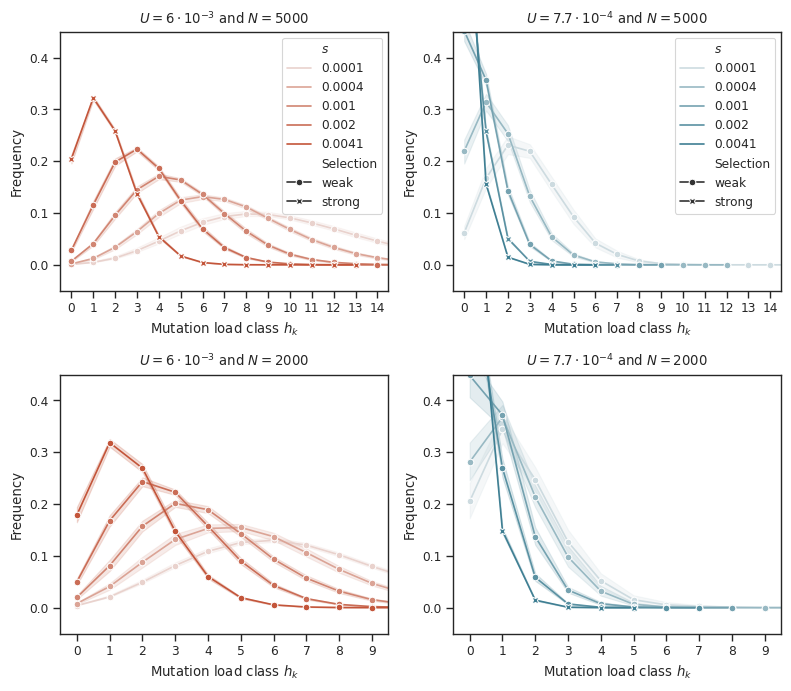

In [340]:
sns.set(context="paper", style="ticks", font_scale=1)
fig, ax = plt.subplots(2, 2, figsize=(8, 7))


c1 = sns.diverging_palette(220, 20)[0]
c2 = sns.diverging_palette(220, 20)[2]
cmap_blues = LinearSegmentedColormap.from_list('custom_cmap', [c2, c1])
c1 = sns.diverging_palette(220, 20)[-3]
c2 = sns.diverging_palette(220, 20)[-1]
cmap_reds = LinearSegmentedColormap.from_list('custom_cmap', [c1, c2])


sns.lineplot(
    data = profile_006_long.loc[profile_006_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])],
    x="$h_k$",
    y="freq",
    style="Strength",
    markers=True,
    dashes=False,
    hue="s",
    hue_norm=LogNorm(),
    errorbar="ci",
    palette=cmap_reds,
    ax=ax[0, 0]
)


ax[0, 0].set_xticks(np.arange(0, 100))
ax[0, 0].set_xlim(-0.05*10, 0.05 * 10 + 14)
ax[0, 0].set_ylim(-0.05, 0.45)


sns.lineplot(
    data = profile_00077_long.loc[profile_00077_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])],
    x="$h_k$",
    y="freq",
    style="Strength",
    markers=True,
    dashes=False,
    hue="s",
    hue_norm=LogNorm(),
    errorbar="ci",
    palette=cmap_blues,
    ax=ax[0, 1]
)


ax[0, 1].set_xticks(np.arange(0, 100))
ax[0, 1].set_xlim(-0.05*10, 0.05 * 10 + 14)
ax[0, 1].set_ylim(-0.05, 0.45)


sns.lineplot(
    data = profile_006_2k_long.loc[profile_006_2k_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:9])],
    x="$h_k$",
    y="freq",
    style="Strength",
    markers=True,
    dashes=False,
    hue="s",
    hue_norm=LogNorm(),
    errorbar="ci",
    palette=cmap_reds,
    ax=ax[1, 0]
)


ax[1, 0].set_xticks(np.arange(0, 100))
ax[1, 0].set_xlim(-0.05*10, 0.05 * 10 + 9)
ax[1, 0].set_ylim(-0.05, 0.45)


sns.lineplot(
    data = profile_00077_2k_long.loc[profile_00077_2k_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:9])],
    x="$h_k$",
    y="freq",
    style="Strength",
    markers=True,
    dashes=False,
    hue="s",
    hue_norm=LogNorm(),
    errorbar="ci",
    palette=cmap_blues,
    ax=ax[1, 1]
)


ax[1, 1].set_xticks(np.arange(0, 100))
ax[1, 1].set_xlim(-0.05*10, 0.05 * 10 + 9)
ax[1, 1].set_ylim(-0.05, 0.45)


ax[0, 0].set_title("$U=6 \cdot 10^{-3}$ and $N=5000$")
ax[0, 1].set_title("$U=7.7 \cdot 10^{-4}$ and $N=5000$")
ax[1, 0].set_title("$U=6 \cdot 10^{-3}$ and $N=2000$")
ax[1, 1].set_title("$U=7.7 \cdot 10^{-4}$ and $N=2000$")

legend1 = ax[0, 0].legend(ncol=1)
legend2 = ax[0, 1].legend(ncol=1)

legend1.texts[0].set_text("$s$")
legend1.texts[6].set_text("Selection")
legend2.texts[0].set_text("$s$")
legend2.texts[6].set_text("Selection")

ax[1, 0].get_legend().remove()
ax[1, 1].get_legend().remove()


for ax_, _ in np.ndenumerate(np.zeros(ax.shape)):
    ax[ax_].set_xlabel("Mutation load class $h_k$")
    ax[ax_].set_ylabel("Frequency")



plt.tight_layout()
plt.show()
plt.close()

In [323]:
ax.shape

(2, 2)

In [261]:
sns.color_palette("BuGn")

[(0.8853517877739331, 0.9562168396770473, 0.9668281430219147),
 (0.7419607843137255, 0.9027297193387159, 0.868958093041138),
 (0.516078431372549, 0.8108573625528642, 0.7273510188389081),
 (0.31578623606305267, 0.7152633602460592, 0.5384390618992695),
 (0.17139561707035755, 0.5849288735101883, 0.3263514033064206),
 (0.017762399077277974, 0.44267589388696654, 0.18523644752018453)]

In [327]:
ax[0, 0].set_ylabel("Freque")

Text(23.999999999999993, 0.5, 'Freque')

In [241]:
360 / 2

180.0

## Save data and figure

### 